In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing as pp
from operator import itemgetter
from scipy.sparse import csr_matrix, csc_matrix, vstack
from scipy.sparse.linalg import norm
from sklearn.model_selection import KFold

In [2]:
R = np.loadtxt("rating.txt", dtype="int", usecols=(0,1,3))
t = np.loadtxt("trust.txt", dtype="int", usecols=(0,1))
#R = np.loadtxt("simple.txt", dtype="int", usecols=(0,1,2))
#t = np.loadtxt("simple_trust.txt", dtype="int", usecols=(0,1))
num_users = max(R[:,0])
num_items = max(R[:,1])
trust_data = np.ones((len(t),), dtype=int)
X = csr_matrix((R[:,2],(R[:,0]-1,R[:,1]-1)), shape=(num_users,num_items))
T = csr_matrix((trust_data,(t[:,0]-1,t[:,1]-1)), shape=(num_users,num_users))

# rebuild R to include only unique entries and be zero based
coo = X.tocoo()
R = np.column_stack((coo.row, coo.col, coo.data))
np.random.seed(999)
np.random.shuffle(R)

In [3]:
num_ratings = X.getnnz()
sparsity = 100-num_ratings/(num_users*num_items)*100
num_trust = T.getnnz()

stats = {
    "Data sparsity:": str(round(sparsity,5))+"%",
    "Number of users:": num_users,
    "Number of items:": num_items,
    "Number of ratings:": num_ratings,
    "Number of trust links:": num_trust
}

for k, v in stats.items():
    print(f'{k:<25} {v}')

Data sparsity:            99.98611%
Number of users:          22166
Number of items:          296277
Number of ratings:        912441
Number of trust links:    300091


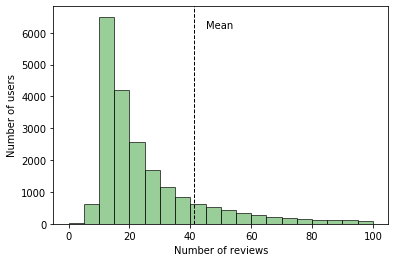

Number of users with no ratings:    2
Minimum reviews per user (>0):      1
Maximum reviews per user:           5337
Mean reviews per user:              41


In [4]:
max_user_reviews = 100
per_user = X.astype(bool).sum(1).A1
mean_reviews_per_user = np.mean(per_user)

x = sorted([n for n in per_user if n <= max_user_reviews]) 
plt.hist(x, bins=int(max_user_reviews/5), color='#63b463', edgecolor='k', alpha=0.65)
plt.axvline(mean_reviews_per_user, color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')
_, max_ = plt.ylim()
plt.text(mean_reviews_per_user + mean_reviews_per_user/10, max_ - max_/10, 'Mean')
plt.show()

stats = {
    "Number of users with no ratings:": len(per_user[per_user==0]),
    "Minimum reviews per user (>0):": min(per_user[per_user>0]),
    "Maximum reviews per user:": max(per_user),
    "Mean reviews per user:": int(round(mean_reviews_per_user)),
}

for k, v in stats.items():
    print(f'{k:<35} {v}')

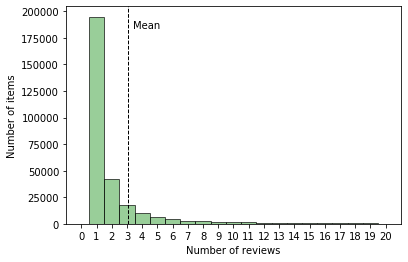

Minimum reviews per item:      1
Maximum reviews per item:      1742
Mean reviews per item:         3


In [5]:
max_item_reviews = 21
per_item = X.astype(bool).sum(0).A1
mean_reviews_per_item = np.mean(per_item)

x = sorted([n for n in per_item if n <= max_item_reviews])
plt.hist(x, bins=np.arange(21)-0.5, color='#63b463', edgecolor='k', alpha=0.65)
plt.xticks(range(21))
plt.xlim([-1, 21])
plt.axvline(mean_reviews_per_item, color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Number of reviews')
plt.ylabel('Number of items')
_, max_ = plt.ylim()
plt.text(mean_reviews_per_item + mean_reviews_per_item/10, max_ - max_/10, 'Mean')
plt.show()

stats = {
    "Minimum reviews per item:": min(per_item),
    "Maximum reviews per item:": max(per_item),
    "Mean reviews per item:": int(round(mean_reviews_per_item))
}

for k, v in stats.items():
    print(f'{k:<30} {v}')

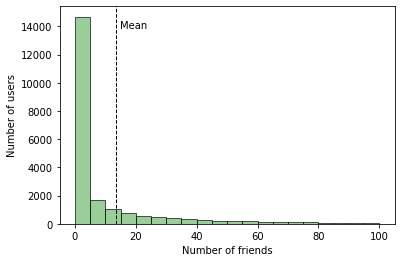

Number of users with no friends:    13652
Minimum friends per user (>0):      1
Maximum friends per user:           1303
Mean friends per user:              14


In [6]:
max_user_trust = 100
trust_per_user = T.sum(1).A1
mean_trusted_per_user = np.mean(trust_per_user)

x = sorted([n for n in trust_per_user if n <= max_user_trust]) 
plt.hist(x, bins=int(max_user_trust/5), color='#63b463', edgecolor='k', alpha=0.65)
plt.axvline(mean_trusted_per_user, color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Number of friends')
plt.ylabel('Number of users')
_, max_ = plt.ylim()
plt.text(mean_trusted_per_user + mean_trusted_per_user/10, max_ - max_/10, 'Mean')
plt.show()

stats = {
    "Number of users with no friends:": len(trust_per_user[trust_per_user==0]),
    "Minimum friends per user (>0):": min(trust_per_user[trust_per_user>0]),
    "Maximum friends per user:": max(trust_per_user),
    "Mean friends per user:": int(round(mean_trusted_per_user)),
}

for k, v in stats.items():
    print(f'{k:<35} {v}')

In [7]:
def get_cosine_similarity(A):
    col_normed_mat = pp.normalize(A.tocsc(), axis=1)
    
    return col_normed_mat * col_normed_mat.T

In [8]:
def get_average_ratings(A):
    B = A.tocsr()
    sums = B.sum(axis=1).A1
    counts = np.diff(B.indptr)
    counts[counts==0] = 1
    
    return sums / counts

In [9]:
def get_trust_network(T):
    propagated_network = None
    friend_weight = 0.4
    friend_of_friend_weight = 0.2
    def propagate(friends_ids):
        # sum all friends of friends in one row
        row = csr_matrix(np.ones(len(friends_ids))) * T[friends_ids]
        # set friends of friends weights
        row.data = np.repeat(friend_of_friend_weight, len(row.data))
        # reset direct friends weights
        data = np.repeat(friend_weight, len(friends_ids))
        coords = (np.zeros(len(friends_ids), dtype=int), friends_ids)
        row = row + csr_matrix((data, coords), shape=T[0].shape)
        row[0,[friends_ids]] = friend_weight
        return csr_matrix(row)
    
    def similarity(sim, trust):
        # binary similarity matrix
        bin_sim = csr_matrix((np.ones(len(sim.data)), sim.indices, sim.indptr), dtype=int, shape=sim.shape)
        # trust/sim intersection matrix
        trust_sim = bin_sim + bin_sim.multiply(trust)
        # trust leftover matrix
        trust_rest = trust - trust.multiply(bin_sim)
        
        return sim.multiply(trust_sim) + trust_rest
    
    def compute(sim, level):
        nonlocal propagated_network
        if level == 1:
            return similarity(sim, T*friend_weight)
        if level == 2:
            if propagated_network is None:
                propagated_network = vstack(list(map(propagate, T.tolil().rows)))
            return similarity(sim, propagated_network)
        else:
            return sim                   
        
    return compute    

In [10]:
import time
def get_neighbours(S, k, ratings, user_id):
    s = time.perf_counter()
    all_neighbours = S[user_id]
    indptr = [0, len(ratings.indices)]
    data = np.ones(len(ratings.indices))
    bin_ratings = csr_matrix((data, ratings.indices, indptr), shape=all_neighbours.shape)
    rating_neighbours = all_neighbours.multiply(bin_ratings)    

    if rating_neighbours.getnnz() == 0:
        return ([], [])
    
    #print("nei: {}".format(all_neighbours.count_nonzero()))
    #print("rating_n: {}".format(round(time.perf_counter()-s,6)))
    s = time.perf_counter()
    pairs = zip(rating_neighbours.data, rating_neighbours.indices)
    s = time.perf_counter()
    ordered = sorted(pairs, key=itemgetter(0), reverse=True)[:k]
    #print("ordered: {}".format(round(time.perf_counter()-s,6)))
    
    #if len(pairs) == 0:
    #    return ([], [])
    #else:
    return map(list, zip(*ordered))

In [11]:
import time
def predict(U, S, A, k, user_id, item_id):
    
    # get neighbours of user_id that rated item_id, sorted by similarity
    ratings = U[:,item_id]
    weights, neighbours = get_neighbours(S, k, ratings, user_id)

    #print("u {}, i {}".format(user_id, item_id))
    #print("r {}, w {}, n {}".format(ratings.T.todense(), np.round(weights,3), neighbours))
    
    #print("p1: {}".format(time.perf_counter()-s))
      
    # return average rating in 1-5 scale if there are no neighbours left or their weights are 0
    #print(len(neighbours), user_id, item_id, ratings.count_nonzero())
    if len(neighbours) == 0 or sum(weights) == 0:
        return -1

    # compute users' average ratings and weights
    s=time.perf_counter()
    user_avg = A[user_id]
    neighbours_avg = A[neighbours]

    # compute weighted ratings
    ratings = sum(weights * (ratings[neighbours].T - neighbours_avg).A1)/sum(np.abs(weights))
    #print(user_avg, ratings, user_avg+ratings)
    rating = user_avg + ratings
    #print("p2: {}".format(time.perf_counter()-s))
    
    #print(time.perf_counter()-s)   
    if rating < 1:
        return 1
    elif rating > 5:
        return 5
    else:
        return rating

In [12]:
def evaluate(R, sums, tsums, ftrust, knn, train_index, test_index, tests_per_fold, trust_level, max_ratings):
    # create a training matrix with the same shape as ratings R
    #print("preparing evaluation data...")
    train_set = R[train_index]
    s = time.perf_counter()
    U = csc_matrix((train_set[:,2],(train_set[:,0],train_set[:,1])), shape=(num_users, num_items))
    #print("U")
    #print(U.todense())
    S = ftrust(get_cosine_similarity(U), trust_level)
    #print("S")
    #print(S.todense())
    A = get_average_ratings(U)
    #print("A")
    #print(A)
    #print("prep: {}".format(round(time.perf_counter()-s,6)))
    # get a view of the test set
    train_size = test_index[-1]-test_index[0]+1
    np.random.seed(12345)
    if tests_per_fold < test_index[-1]-test_index[0]+1:
        idx = np.random.permutation(np.arange(train_size))[:tests_per_fold]
        y = R[test_index[0]:test_index[-1]+1][idx]
    else:
        y = R[test_index[0]:test_index[-1]+1]
    # get predictions for the test set
    #print("running {} predictions...".format(tests_per_fold))
    s = time.perf_counter()
    if max_ratings[0] is not None:
        y = y[sums[y[:,0]] <= max_ratings[0]]
    if max_ratings[1] is True:
        y = y[tsums[y[:,0]] > 0]   
    if len(y) == 0:
        return (0, 0, 0, 0, 0)
    
    predictions = np.fromiter((predict(U, S, A, knn, u, i) for u,i,_ in y), y.dtype, count=len(y))
    mask = predictions > -1
    #print("y {}".format(y[:,2]))
    #print("pred {}".format(predictions))
    t=time.perf_counter()-s
    #print(t)
    diff = y[:,2][mask] - np.round(predictions[mask]).astype(int)
    #print("diff {}".format(diff))
    #print(y, predictions)
    
    # return MAE, RMSE
    return (sum(np.abs(diff))/len(diff), np.sqrt(diff.dot(diff)/len(diff)), len(predictions) - len(mask), len(y), t)

In [13]:
#S = get_pearson_similarity(X.tocsc())
#A = get_average_ratings(X)
#predict(X.tocsc(), S, A, 2, 0, 3)
#%timeit X.sum(axis=1).A1 / np.diff(X.indptr)

In [14]:
splits = 10
tests_per_fold = 5000
neighbours = [5, 10,20,30,50,40,60]
neighbours = [10,30,50]
trust_levels = [0,1,2]
# tuples with max reviews (None for all) and bool if include only people trusting others
rating_threshold = {"all": (None, False), "all_trust": (None, True), "cold": (20, False), "cold_trust": (20, True)}

ftrust = get_trust_network(T)
sums = X.getnnz(axis=1)
tsums = T.getnnz(axis=1)
kf = KFold(n_splits=splits)

runs = len(trust_levels) * splits * len(neighbours) * len(rating_threshold)
print("Evaluation [{} runs]: ".format(runs), end='')
i = 1
results = []
s = time.perf_counter()
for threshold, max_ratings in rating_threshold.items():
    for trust_level in trust_levels:
        for k in neighbours:
            err_mae, err_rmse, t, p_missed, p_total = [], [], [], 0, 0
            for train_index, test_index in kf.split(R):
                #print("next split")
                mae, rmse, missed, total, t = evaluate(R, sums, tsums, ftrust, k, train_index, test_index, 
                                                       tests_per_fold, trust_level, max_ratings)
                if total > 0:
                    err_rmse.append(rmse)
                    err_mae.append(mae)
                    p_total += total
                    p_missed += missed
                if i %(runs/10) == 0:
                    print("{}%".format(int(i/runs*100)), end = ' ')
                i += 1
            if p_total > 0:
                results.append({"rmse": np.mean(err_rmse), "mae": np.mean(err_mae), 
                                "k": k, "avgtime": np.mean(t), "trust_level": trust_level,
                                "missed": p_missed, "total": p_total, "threshold": threshold})

import datetime
print("Done [{}]".format(datetime.timedelta(seconds=int(time.perf_counter()-s))))

Evaluation [360 runs]: 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% Done [0:28:04]


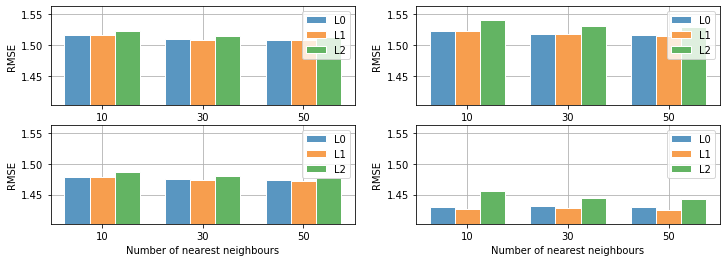

In [15]:
sorted_results = sorted(results, key=lambda x: x["k"])
def plot(threshold):
    L0 = [x["rmse"] for x in sorted_results if x["trust_level"] == 0 and x["threshold"] == threshold]
    L1 = [x["rmse"] for x in sorted_results if x["trust_level"] == 1 and x["threshold"] == threshold]
    L2 = [x["rmse"] for x in sorted_results if x["trust_level"] == 2 and x["threshold"] == threshold]
    barWidth = 0.25 

    r1 = np.arange(len(L0))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    plt.bar(r1, L0, color='#5996c1', width=barWidth, edgecolor='white', label='L0', zorder=3)
    plt.bar(r2, L1, color='#f79e4e', width=barWidth, edgecolor='white', label='L1', zorder=3)
    plt.bar(r3, L2, color='#63b463', width=barWidth, edgecolor='white', label='L2', zorder=3)

    plt.xlabel('Number of nearest neighbours')
    plt.ylabel('RMSE')
    plt.xticks([r + barWidth for r in range(len(L0))], neighbours)
    low = min([x["rmse"] for x in results])
    high = max([x["rmse"] for x in results])
    plt.ylim([low-0.2*(high-low), high+0.2*(high-low)])

    plt.grid(zorder=0)
    plt.legend()

plt.figure(figsize=(12,4))
plt.subplot(2,2,1)
plot("all")
plt.subplot(2,2,2)
plot("all_trust")
plt.subplot(2,2,3)
plot("cold")
plt.subplot(2,2,4)
plot("cold_trust")
#63b463
#d96060
#ac8cc8    
plt.show()